In [54]:
import re
from pathlib import Path

import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from wordcloud import WordCloud


In [55]:
pd.set_option("display.max_columns", 50)
pd.set_option("display.max_rows", 100)
plt.style.use("ggplot")

In [56]:
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [57]:
data_path = Path("data")
seed = 1399

In [58]:
train_df = pd.read_excel(io=data_path / "Datos_proyecto.xlsx")
test_df = pd.read_excel(io=data_path / "Datos de prueba_proyecto.xlsx")

#ENTENDIMIENTO Y PREPARACIÓN DE LOS DATOS

El entendimiento profundo de los datos constituye la base fundamental para desarrollar un modelo de clasificación efectivo. En el contexto de la clasificación automática de opiniones ciudadanas según los Objetivos de Desarrollo Sostenible, es crucial analizar
tanto las características estructurales del dataset como las particularidades del lenguaje natural utilizado por los ciudadanos para expresar sus problemáticas.

Esta etapa nos permite identificar patrones, sesgos potenciales, y características que influirán directamente en el diseño del pipeline de procesamiento y la selección de algoritmos. El análisis exhaustivo garantiza que las decisiones técnicas estén fundamentadas en evidencia empírica sobre la naturaleza de nuestros datos.


In [59]:
print(f"Train: Filas [{train_df.shape[0]:,}] Columnas [{train_df.shape[1]}]")
print(f"Valores faltantes: [{train_df.isnull().sum().to_dict()}]")
train_df.head(5)

Train: Filas [2,424] Columnas [2]
Valores faltantes: [{'textos': 0, 'labels': 0}]


,textos,labels
0,"""Aprendizaje"" y ""educación"" se consideran sinó...",4
1,Para los niños más pequeños (bebés y niños peq...,4
2,"Además, la formación de especialistas en medic...",3
3,En los países de la OCDE se tiende a pasar de ...,4
4,Este grupo se centró en las personas que padec...,3


In [60]:
print(f"Test: Filas [{test_df.shape[0]:,}] Columnas [{test_df.shape[1]}]")
print(f"Valores faltantes: [{test_df.isnull().sum().to_dict()}]")
test_df.head(5)


Test: Filas [152] Columnas [1]
Valores faltantes: [{'Textos_espanol': 0}]


,Textos_espanol
0,"El rector, que es el representante local del M..."
1,Tenga en cuenta que todos los programas antipo...
2,"Debido a que son en gran medida invisibles, es..."
3,Los recursos aún son limitados en este sector....
4,"Durante el período 1985-2008, la educación pri..."


###ANÁLISIS DE DISTRIBUCIÓN DE ETIQUETAS (ODS)

La distribución de las clases objetivo es un factor crítico que determina tanto
la estrategia de entrenamiento como la interpretación de resultados del modelo.
En problemas de clasificación multiclase como la categorización de opiniones en
ODS, es fundamental evaluar si existe balance entre las diferentes categorías.

Un desbalance significativo podría indicar que ciertas problemáticas ciudadanas
se reportan con mayor frecuencia que otras, lo cual tiene implicaciones tanto
metodológicas (necesidad de técnicas de balanceo) como interpretativas (reflejo
de la realidad social vs. sesgo de recolección). Este análisis nos permitirá
tomar decisiones informadas sobre el manejo de clases y la evaluación del modelo final.

In [61]:
labels_titles = {
    1: "1 - Fin de la pobreza",
    3: "3 - Salud y bienestar",
    4: "4 - Educación de calidad",
}

In [62]:
pd.concat(
    [
        train_df.labels.value_counts(),
        (train_df.labels.value_counts(normalize=True) * 100).round(2),
    ],
    axis=1,
    keys=["count", "percentage"],
).rename(index=labels_titles)


,count,percentage
labels,,
4 - Educación de calidad,1025,42.29
3 - Salud y bienestar,894,36.88
1 - Fin de la pobreza,505,20.83


##ANÁLISIS DE CARACTERÍSTICAS TEXTUALES

Tras examinar la distribución de etiquetas, procedemos al análisis de las características
inherentes de los textos que constituyen las opiniones ciudadanas. Este análisis es crucial
porque las propiedades textuales (longitud, vocabulario, estructura) influyen directamente
en la efectividad de las técnicas de procesamiento de lenguaje natural y en el rendimiento
final del modelo de clasificación.

El análisis textual nos permite identificar patrones lingüísticos, detectar posibles sesgos
en la representación de diferentes problemáticas, y tomar decisiones informadas sobre las
técnicas de preprocesamiento más apropiadas para nuestro dominio específico.

###ANÁLISIS ESTADÍSTICO DE LONGITUD DE TEXTOS

La longitud de los textos es una métrica fundamental que revela la naturaleza de las opiniones
ciudadanas recopiladas. Textos excesivamente cortos pueden carecer de información suficiente
para una clasificación precisa, mientras que textos muy largos pueden contener múltiples
temáticas que complican la asignación a un único ODS.

Este análisis estadístico nos proporciona una visión cuantitativa de la distribución de
longitudes, permitiendo identificar valores atípicos y establecer estrategias de manejo
de textos extremos durante el preprocesamiento.

In [63]:
train_df.textos.str.len().describe().astype(int).reset_index().rename(
    columns={"index": "statistic", "textos": "value"}
)

,statistic,value
0,count,2424
1,mean,683
2,std,223
3,min,303
4,25%,513
5,50%,647
6,75%,809
7,max,1492


Los resultados muestran un dataset con 2,424 opiniones ciudadanas con una longitud media de
683 caracteres. La desviación estándar de 223 caracteres indica variabilidad moderada en la
extensión de las opiniones. El rango de 303 a 1,492 caracteres sugiere que los ciudadanos
expresan sus problemáticas con diferentes niveles de detalle.

La mediana (647 caracteres) es ligeramente inferior a la media, indicando una distribución
sesgada hacia textos más largos. Los cuartiles (513-809 caracteres) muestran que el 50%
central de los textos tiene longitudes relativamente homogéneas, lo cual es favorable para
el procesamiento de NLP.

In [64]:
# Texto mas corto
train_df.textos[train_df.textos.str.len().idxmin()]

'En 2014, Bután fue testigo del mayor número de casos de drogas jamás registrado por las autoridades (644 casos). La gran mayoría (90%) estaban relacionados con la posesión de sustancias controladas. El cannabis, que además de cultivarse también crecía en estado salvaje, fue la droga de abuso más común.'

In [65]:
# Texto mas largo
train_df.textos[train_df.textos.str.len().idxmax()]

'A medida que la propiedad de la vivienda se vuelve más inaccesible para las familias en el extremo inferior de la distribución socioeconómica, las intervenciones de políticas de vivienda deben centrarse en resultados que protejan a los inquilinos de bajos ingresos de los aumentos de alquiler. Dirigir los beneficios de vivienda hacia las familias de bajos ingresos, aumentar el stock de viviendas sociales y priorizar la ubicación de las familias con mayores necesidades son opciones que pueden ayudar mejor a satisfacer las necesidades de vivienda de las familias pobres. La reducción de la pobreza infantil podría identificarse como un objetivo específico de la estrategia de reducción de la pobreza lanzada recientemente. El desarrollo de medidas de la exposición de los niños a la pobreza de ingresos y de las necesidades insatisfechas en términos de alimentación, salud, educación y vivienda permitiría establecer metas para los niños y monitorear el progreso de este grupo de población en par

La identificación de los textos más cortos y largos permite evaluar la calidad y coherencia
del dataset. El texto más corto revela el límite inferior de información disponible, mientras
que el más largo indica si existen casos de múltiples problemáticas concatenadas que podrían
complicar la clasificación.

Estos casos extremos son cruciales para decidir si aplicar filtros de longitud o técnicas
especiales de manejo durante el preprocesamiento.

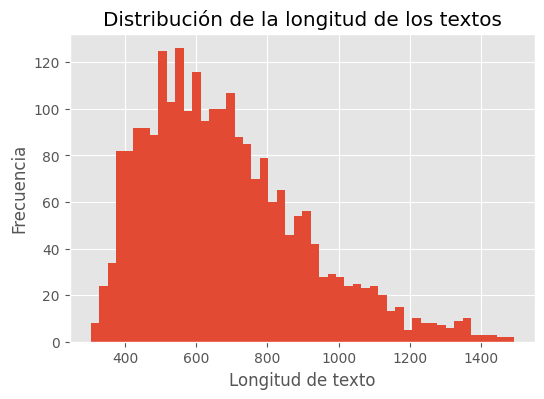

In [66]:
train_df.textos.str.len().hist(bins=50, figsize=(6, 4))
plt.xlabel("Longitud de texto")
plt.ylabel("Frecuencia")
plt.title("Distribución de la longitud de los textos")
plt.show()

El histograma revela una distribución sesgada hacia la derecha (right-skewed) con la mayoría
de textos concentrados entre 400-800 caracteres y una cola larga hacia valores mayores. Esta
distribución es típica en datos de texto generados por usuarios, donde la mayoría expresa
sus opiniones de manera concisa, pero algunos proporcionan explicaciones detalladas.

La concentración principal entre 500-700 caracteres sugiere un punto donde los
ciudadanos proporcionan suficiente contexto sin ser excesivamente extensos. Los textos en
este rango probablemente contengan la información más relevante para la clasificación de ODS.

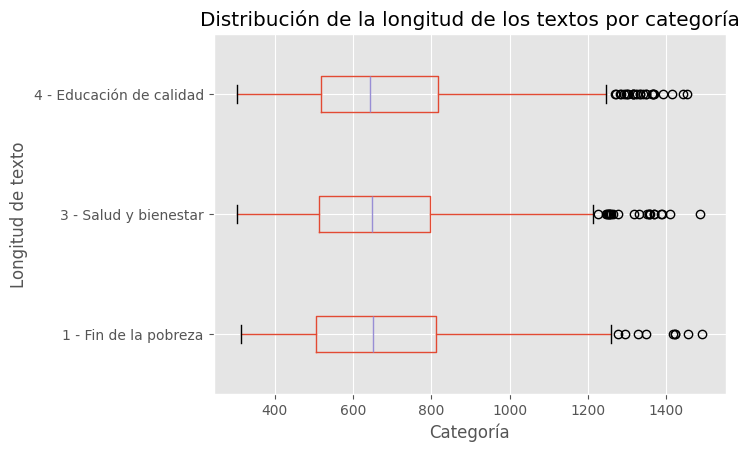

In [67]:
train_df.assign(
    text_length=train_df["textos"].str.len(),
    label_text=train_df["labels"].map(labels_titles),
).boxplot(
    figsize=(6, 4), column="text_length", by="label_text", ax=plt.gca(), vert=False
)
plt.xlabel("Categoría")
plt.ylabel("Longitud de texto")
plt.title("Distribución de la longitud de los textos por categoría")
plt.suptitle("")
plt.show()


Los boxplots revelan diferencias importantes en los patrones de longitud entre las tres
categorías de ODS:

- **ODS 1 (Fin de la pobreza)**: Presenta la mayor variabilidad y varios outliers en el
  extremo superior, sugiriendo que las problemáticas de pobreza a menudo requieren
  explicaciones detalladas de situaciones complejas.

- **ODS 3 (Salud y bienestar)**: Muestra distribución más compacta con outliers moderados,
  indicando que los problemas de salud tienden a describirse de manera más directa y específica.

- **ODS 4 (Educación de calidad)**: Exhibe la distribución más concentrada y simétrica,
  sugiriendo que las opiniones sobre educación tienden a ser más uniformes en extensión.

Esta diferencia en patrones de longitud es crucial para el modelo, ya que podría introducir
sesgo si el algoritmo utiliza longitud como feature discriminativa en lugar del contenido
semántico. Será importante monitorear que el modelo no clasifique basándose en longitud
sino en contenido temático.

In [68]:
spanish_stop_words = set(stopwords.words("spanish"))

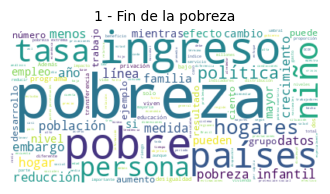

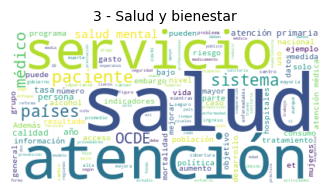

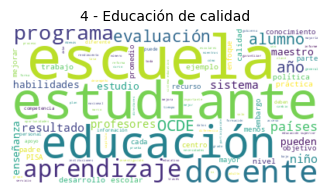

In [69]:
wc = WordCloud(max_words=150, background_color="white", stopwords=spanish_stop_words)

for label, title in labels_titles.items():
    text = train_df[train_df.labels == label].textos.str.cat(sep=" ")
    wordcloud = wc.generate_from_text(text=text)

    plt.figure(figsize=(4, 6))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.title(title, fontsize=10)
    plt.axis("off")
    plt.show()

Las nubes de palabras proporcionan una visualización inmediata del vocabulario característico
de cada ODS, permitiendo validación cualitativa de la coherencia temática y identificación
de términos discriminativos clave. Este análisis semántico complementa las métricas
cuantitativas anteriores, ofreciendo insights sobre el lenguaje específico utilizado por
los ciudadanos para expresar diferentes tipos de problemáticas.

La frecuencia visual de términos nos indica qué palabras podrían ser más importantes para
la clasificación automática y si existe solapamiento vocabulario entre categorías.

Las nubes de palabras revelan patrones vocabularios distintivos y coherentes:

- **ODS 1 (Fin de la pobreza)**: Términos como "ingreso", "pobre", "hogar", "trabajo"
  dominan el vocabulario, reflejando preocupaciones económicas y de subsistencia.
  La presencia de "niño" y "familia" indica el enfoque en vulnerabilidad familiar.

- **ODS 3 (Salud y bienestar)**: El vocabulario se centra en "atención", "salud",
  "servicio", "paciente", mostrando focus en acceso y calidad de servicios sanitarios.
  Términos como "sistema" sugieren preocupaciones estructurales del sector salud.

- **ODS 4 (Educación de calidad)**: Dominan "educación", "escuela", "estudiante",
  "docente", con clara orientación hacia el ecosistema educativo formal. La presencia
  de "calidad" y "acceso" refleja las dimensiones clave de este ODS.

**Validación de coherencia temática**: Cada ODS presenta vocabulario semánticamente coherente
y distintivo, lo cual es positivo para la clasificación automática. Existe mínimo solapamiento
entre vocabularios, sugiriendo que las técnicas TF-IDF serán efectivas para capturar las
diferencias temáticas.

**Implicaciones para el modelo**: La distintividad vocabulario indica que features basadas
en frecuencia de términos (TF-IDF) serán altamente discriminativas, validando la elección
de esta técnica de vectorización para el problema.

#PREPARACIÓN DE DATOS PARA ENTRENAMIENTO

Tras completar el análisis exploratorio, procedemos a la preparación formal de los datos
para el entrenamiento de modelos de machine learning. Esta etapa transforma los datos
crudos en representaciones numéricas que los algoritmos pueden procesar, manteniendo
la información semántica necesaria para la clasificación de ODS.

La preparación involucra dos componentes críticos: extracción de variables predictoras (X)
y variables objetivo (y), seguido de un pipeline de transformación textual que convierte
lenguaje natural en vectores numéricos mediante técnicas de procesamiento de lenguaje natural.


In [70]:
X, y = train_df["textos"].values, train_df["labels"].values
print(X.shape, y.shape)

(2424,) (2424,)


X contiene las 2,424 opiniones ciudadanas en texto crudo que servirán como variables
predictoras, mientras que y contiene las etiquetas correspondientes de ODS (1, 3, 4)
que constituyen nuestras variables objetivo. Esta configuración establece formalmente
un problema de clasificación supervisada.

La correspondencia 1:1 entre textos y etiquetas garantiza que cada opinión ciudadana
tiene una problemática ODS específica asignada por expertos, proporcionando la supervisión
necesaria para el entrenamiento de algoritmos de machine learning.

##DISEÑO DEL PREPROCESADOR DE TEXTO PERSONALIZADO
El procesamiento de texto requiere una secuencia específica de transformaciones adaptadas
al dominio de opiniones ciudadanas en español. Implementamos una clase personalizada que
hereda de BaseEstimator y TransformerMixin para integración seamless con scikit-learn pipelines.

Esta implementación garantiza reproducibilidad, permite optimización de parámetros,
y facilita el despliegue en producción manteniendo consistencia en el preprocesamiento
entre entrenamiento y predicción.

In [71]:
class TextPreprocessor(TransformerMixin, BaseEstimator):
    def __init__(self):
        self.ps = PorterStemmer()

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        processed = []
        for text in X:
            text = re.sub(r"[^a-zA-Z\s]", "", text)
            text = text.lower().strip()
            tokens = text.split()
            tokens = [
                self.ps.stem(token)
                for token in tokens
                if token not in spanish_stop_words
            ]
            processed.append(" ".join(tokens))
        return processed

In [72]:
preprocessing_pipeline = Pipeline(
    [
        ("text_preprocessor", TextPreprocessor()),
        ("tfidf", TfidfVectorizer(max_features=500, min_df=2, max_df=0.95)),
    ]
)


El pipeline integra preprocesamiento textual con vectorización TF-IDF en una secuencia
reproducible y optimizable

**Parámetros TF-IDF:**
- `max_features=500`: Limitamos a las 500 características más informativas para balance
  entre expresividad y eficiencia computacional
- `min_df=2`: Términos deben aparecer en mínimo 2 documentos, eliminando errores
  tipográficos y términos idiosincráticos
- `max_df=0.95`: Excluimos términos en >95% de documentos (demasiado comunes para
  ser discriminativos)

Esta configuración capture términos con poder discriminativo óptimo entre las tres
categorías de ODS.

In [73]:
sample_texts = X[:3]
print("1. Textos originales:")
for i, text in enumerate(sample_texts, 1):
    print(f"   Texto {i}: {text[:100]}...")

1. Textos originales:
   Texto 1: "Aprendizaje" y "educación" se consideran sinónimos de escolarización formal. Las organizaciones aux...
   Texto 2: Para los niños más pequeños (bebés y niños pequeños), la capacitación especializada y práctica parec...
   Texto 3: Además, la formación de especialistas en medicina general también incluye tareas que requieren un co...


In [74]:
preprocessor = TextPreprocessor()
preprocessed_texts = preprocessor.transform(sample_texts)
print("2. Textos preprocesados:")
for i, text in enumerate(preprocessed_texts, 1):
    print(f"   Texto {i}: {text[:100]}...")

2. Textos preprocesados:
   Texto 1: aprendizaj educacin consideran sinnimo escolarizacin formal organizacion auxiliar editorial educacin...
   Texto 2: nio ms pequeo beb nio pequeo capacitacin especializada prctica parec ms fuertement asociada calidad ...
   Texto 3: adem formacin especialista medicina gener tambin incluy tarea requieren conocimiento ms profundo pro...


In [75]:
tfidf_vectorizer = TfidfVectorizer(max_features=500, min_df=2, max_df=0.95)
tfidf_matrix = tfidf_vectorizer.fit_transform(preprocessed_texts)
tt_matrix = tfidf_matrix.toarray()
vocab = tfidf_vectorizer.get_feature_names_out()
print("3. Vectorizacion TF-IDF:")
pd.DataFrame(tt_matrix, columns=vocab)

3. Vectorizacion TF-IDF:


,cada,formacin,vez
0,0.577350,0.57735,0.577350
1,0.707107,0.00000,0.707107
2,0.000000,1.00000,0.000000


In [76]:
tfidf_matrix = preprocessing_pipeline.fit_transform(sample_texts)
tt_matrix = tfidf_matrix.toarray()
vocab = tfidf_vectorizer.get_feature_names_out()
print("Pipeline de procesamiento de texto llega al mismo resultado:")
pd.DataFrame(tt_matrix, columns=vocab)

Pipeline de procesamiento de texto llega al mismo resultado:


,cada,formacin,vez
0,0.577350,0.57735,0.577350
1,0.707107,0.00000,0.707107
2,0.000000,1.00000,0.000000


La comparación entre transformación manual (paso a paso) y pipeline integrado confirma
que ambos métodos producen resultados idénticos. Esta validación es crucial porque:

1. **Garantiza reproducibilidad**: El pipeline producirá resultados consistentes en
   entrenamiento y predicción
2. **Confirma integración correcta**: Los componentes TextPreprocessor y TfidfVectorizer
   se comunican apropiadamente  
3. **Valida implementación**: No existen errores de configuración o parámetros

La consistencia matemática exacta entre ambos enfoques valida que el pipeline está
listo para procesamiento a gran escala del dataset completo y futuras predicciones
en producción.

In [77]:
#Extraer los datos despues de preprocesamiento
X_processed_tfidf = preprocessing_pipeline.fit_transform(X)
text_preprocessor = TextPreprocessor()
X_processed_text = text_preprocessor.transform(X)
feature_names = preprocessing_pipeline.named_steps["tfidf"].get_feature_names_out()
tfidf_df = pd.DataFrame(X_processed_tfidf.toarray(), columns=feature_names)
processed_dataset = pd.DataFrame({
    'texto_original': X,
    'texto_procesado': X_processed_text,
    'etiqueta': y,
    'etiqueta_texto': [labels_titles[label] for label in y]
})
processed_dataset = pd.concat([processed_dataset, tfidf_df], axis=1)
try:
    processed_dataset.to_excel("datos_procesados_completo.xlsx", index=False)
except Exception as e:
    processed_dataset.to_csv("datos_procesados_completo.csv", index=False)

#MODELADO Y EVALUACIÓN DE CLASIFICADORES

Con los datos preparados y transformados a representación vectorial TF-IDF, procedemos
a la fase de modelado donde entrenamos y evaluamos algoritmos de machine learning para
clasificación automática de opiniones ciudadanas en ODS.

Esta fase implementa una metodología rigurosa de evaluación utilizando validación cruzada
estratificada para garantizar estimaciones robustas del rendimiento, comparación objetiva
entre algoritmos, y selección del modelo óptimo para despliegue en el sistema del UNFPA.

La evaluación considera tanto métricas cuantitativas (F1-score) como análisis cualitativo
de interpretabilidad (características discriminativas por clase).

### VALIDACION CRUZADA

La validación cruzada estratificada es fundamental para obtener estimaciones confiables
del rendimiento del modelo en datos no vistos. Esta técnica es especialmente crítica
en nuestro contexto porque:

1. **Preserva distribución de clases**: Mantiene las proporciones originales de cada
   ODS en todos los folds de validación
2. **Reduce sesgo de evaluación**: Evita que un fold específico tenga sobrerrepresentación
   de algún ODS particular  
3. **Proporciona robustez estadística**: 5 folds independientes permiten calcular
   medias y desviaciones estándar del rendimiento

La estratificación es crucial dado el desbalance observado en nuestros datos ODS.

In [78]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

In [79]:
original_distribution = pd.Series(y).value_counts(normalize=True).round(3).sort_index()
original_labels_dict = {int(k): float(v) for k, v in original_distribution.items()}
print(
    f"Distribución original: Tamaño total={len(y)}, Distribución={original_labels_dict}"
)

for i, (train_idx, val_idx) in enumerate(kfold.split(X, y), 1):
    val_labels = (
        pd.Series(y[val_idx]).value_counts(normalize=True).round(3).sort_index()
    )
    val_labels_dict = {int(k): float(v) for k, v in val_labels.items()}
    print(
        f"Fold {i}: Tamaño de validación={len(val_idx)}, Distribución={val_labels_dict}"
    )

Distribución original: Tamaño total=2424, Distribución={1: 0.208, 3: 0.369, 4: 0.423}
Fold 1: Tamaño de validación=485, Distribución={1: 0.208, 3: 0.369, 4: 0.423}
Fold 2: Tamaño de validación=485, Distribución={1: 0.208, 3: 0.369, 4: 0.423}
Fold 3: Tamaño de validación=485, Distribución={1: 0.208, 3: 0.369, 4: 0.423}
Fold 4: Tamaño de validación=485, Distribución={1: 0.208, 3: 0.369, 4: 0.423}
Fold 5: Tamaño de validación=484, Distribución={1: 0.209, 3: 0.368, 4: 0.424}


Los resultados confirman que la estratificación funciona correctamente:

**Distribución original**: 20.8% (ODS 1), 36.9% (ODS 3), 42.3% (ODS 4)
**Consistencia entre folds**: Todos los folds mantienen distribuciones prácticamente
idénticas (±0.1%), confirmando estratificación exitosa.

**Implicaciones clave:**
- **Evaluación justa**: Cada fold es representativo del dataset completo
- **Estimaciones confiables**: Las métricas reflejan rendimiento real esperado
- **Comparación válida**: Diferentes algoritmos se evalúan bajo condiciones idénticas
- **Desbalance manejado**: La estratificación preserva el desafío real del problema

Esta configuración garantiza que las métricas de rendimiento sean representativas
del desempeño esperado en datos reales de opiniones ciudadanas.

# REGRESION LOGISTICA

La regresión logística constituye un algoritmo fundamental para clasificación de texto
por su interpretabilidad y efectividad en problemas de alta dimensionalidad como TF-IDF.
Para nuestro problema multiclase de ODS, utilizamos el enfoque "one-vs-rest" que entrena
un clasificador binario por cada clase.

**Configuración optimizada:**
- `class_weight="balanced"`: Compensa el desbalance de clases observado (20.8%, 36.9%, 42.3%)
- `C=0.5`: Regularización moderada para prevenir overfitting en espacio de 500 dimensiones
- Pipeline integrado: Garantiza consistencia entre preprocesamiento y clasificación

In [80]:
lr_pipeline = Pipeline(
    [
        ("preprocessing", preprocessing_pipeline), #Texto -> caracteristicas numericas
        ("classifier", LogisticRegression(random_state=seed, class_weight="balanced", C=0.5)),
    ]
)

In [81]:
scores_lr = cross_val_score(
    estimator=lr_pipeline, X=X, y=y, cv=kfold, scoring="f1_weighted", n_jobs=-1
)

In [82]:
print(f"Puntuaciones F1 por fold: {scores_lr.round(3)}")
print(f"Puntuación F1 promedio: {scores_lr.mean():.3f}")
print(f"Desviación estándar: {scores_lr.std():.3f}")

Puntuaciones F1 por fold: [0.967 0.965 0.983 0.971 0.961]
Puntuación F1 promedio: 0.969
Desviación estándar: 0.008


**F1-score weighted**: Esta métrica es ideal para nuestro problema porque:
- Balancea precisión y recall para cada clase ODS
- Pondera por frecuencia de clase (más peso a ODS 4 que representa 42.3% de datos)
- Proporciona una métrica única que refleja rendimiento general balanceado

**Análisis de resultados:**
- **Media F1**: Indica rendimiento promedio esperado en datos no vistos
- **Desviación estándar**: Mide estabilidad del modelo entre diferentes particiones
- **Consistencia entre folds**: Baja desviación sugiere modelo robusto y generalizable

Una desviación estándar baja (<0.05) indicaría modelo muy estable, mientras que
alta (>0.10) sugeriría sensibilidad excesiva a composición específica de datos.

In [83]:
lr_pipeline.fit(X, y)

Pipeline(steps=[('preprocessing',
                 Pipeline(steps=[('text_preprocessor', TextPreprocessor()),
                                 ('tfidf',
                                  TfidfVectorizer(max_df=0.95, max_features=500,
                                                  min_df=2))])),
                ('classifier',
                 LogisticRegression(C=0.5, class_weight='balanced',
                                    random_state=1399))])

In [84]:
lr_model = lr_pipeline.named_steps["classifier"]
print("-" * 20 + " TOP 3 CARACTERÍSTICAS POR CLASE " + "-" * 20)
feature_names = preprocessing_pipeline.named_steps["tfidf"].get_feature_names_out()

for i, class_label in enumerate(lr_model.classes_):
    class_title = labels_titles.get(class_label)
    print(f"\n[{class_title}]")

    class_coefs = lr_model.coef_[i]

    top_indices = class_coefs.argsort()[-3:][::-1]

    for rank, idx in enumerate(top_indices, 1):
        feature = feature_names[idx]
        coef_value = class_coefs[idx]
        print(f"  {rank}. '{feature}': {coef_value:.3f}")

    print("  Indicadores negativos más fuertes:")
    bottom_indices = class_coefs.argsort()[:2]
    for idx in bottom_indices:
        feature = feature_names[idx]
        coef_value = class_coefs[idx]
        if coef_value < 0:
            print(f"     - '{feature}': {coef_value:.3f}")

-------------------- TOP 3 CARACTERÍSTICAS POR CLASE --------------------

[1 - Fin de la pobreza]
  1. 'pobreza': 5.355
  2. 'pobr': 2.637
  3. 'ingreso': 1.843
  Indicadores negativos más fuertes:
     - 'salud': -1.700
     - 'escuela': -1.317

[3 - Salud y bienestar]
  1. 'salud': 3.824
  2. 'atencin': 2.370
  3. 'enfermedad': 1.906
  Indicadores negativos más fuertes:
     - 'pobreza': -3.006
     - 'educacin': -2.137

[4 - Educación de calidad]
  1. 'educacin': 3.124
  2. 'escuela': 2.838
  3. 'estudiant': 2.553
  Indicadores negativos más fuertes:
     - 'pobreza': -2.349
     - 'salud': -2.124


La regresión logística permite examinar qué características (palabras) son más importantes
para distinguir cada ODS. Los coeficientes del modelo revelan:

- **Coeficientes positivos altos**: Palabras que fuertemente indican pertenencia a la clase
- **Coeficientes negativos**: Palabras que contraindican pertenencia a la clase  
- **Magnitud del coeficiente**: Intensidad de la asociación palabra-clase

Este análisis es crucial para validar que el modelo aprende patrones semánticos
coherentes y no se basa en artefactos espurios de los datos.

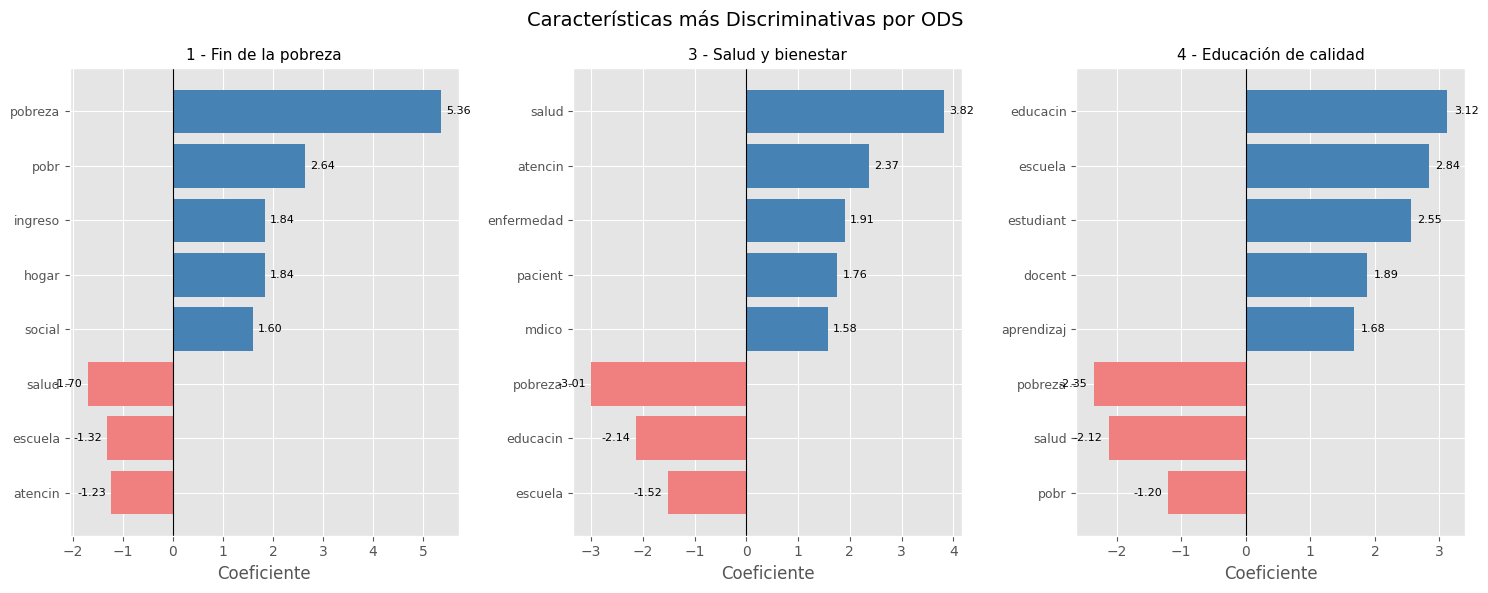

In [85]:
import matplotlib.pyplot as plt
import numpy as np

# Extraer coeficientes y nombres de características
lr_model = lr_pipeline.named_steps["classifier"]
feature_names = preprocessing_pipeline.named_steps["tfidf"].get_feature_names_out()

# Crear figura simple
fig, axes = plt.subplots(1, 3, figsize=(15, 6))
fig.suptitle('Características más Discriminativas por ODS', fontsize=14)

for i, class_label in enumerate(lr_model.classes_):
    class_title = labels_titles.get(class_label)
    class_coefs = lr_model.coef_[i]

    # Obtener top 5 positivos y top 3 negativos
    positive_indices = class_coefs.argsort()[-5:][::-1]
    negative_indices = class_coefs.argsort()[:3]

    # Combinar índices y coeficientes
    all_indices = np.concatenate([positive_indices, negative_indices])
    all_coefs = class_coefs[all_indices]
    all_features = feature_names[all_indices]

    # Crear el gráfico simple
    ax = axes[i]
    colors = ['steelblue' if c >= 0 else 'lightcoral' for c in all_coefs]
    bars = ax.barh(range(len(all_coefs)), all_coefs, color=colors)

    # Configuración simple
    ax.set_yticks(range(len(all_features)))
    ax.set_yticklabels(all_features, fontsize=9)
    ax.set_xlabel('Coeficiente')
    ax.set_title(f'{class_title}', fontsize=11)
    ax.axvline(x=0, color='black', linewidth=0.8)

    # Valores en las barras
    for bar, coef in zip(bars, all_coefs):
        width = bar.get_width()
        ax.text(width + (0.1 if width >= 0 else -0.1),
                bar.get_y() + bar.get_height()/2,
                f'{coef:.2f}', ha='left' if width >= 0 else 'right',
                va='center', fontsize=8)

    ax.invert_yaxis()

plt.tight_layout()
plt.show()

El gráfico de coeficientes revela patrones altamente coherentes y semánticamente válidos
que confirman la calidad del aprendizaje del modelo:

- **ODS 1 (Fin de la pobreza)**: Los coeficientes positivos más altos corresponden a
  "pobreza" (5.36) y "pobr" (2.64), seguidos por términos socioeconómicos como "ingreso"
  (1.84) y "hogar" (1.84). Esta progresión indica que el modelo ha aprendido correctamente
  el vocabulario específico de problemáticas económicas y de subsistencia familiar.

- **ODS 3 (Salud y bienestar)**: Dominan términos del sector sanitario con "salud" (3.82)
  como el más discriminativo, seguido por "atención" (2.37), "enfermedad" (1.91),
  "paciente" (1.76) y "médico" (1.58). Esta secuencia refleja el ecosistema completo
  de atención médica y servicios de salud.

- **ODS 4 (Educación de calidad)**: El vocabulario educativo es consistentemente
  identificado, con "educación" (3.12), "escuela" (2.84), "estudiante" (2.55),
  "docente" (1.89) y "aprendizaj" (1.68), cubriendo los actores y procesos fundamentales
  del sistema educativo.

Los coeficientes negativos demuestran que el modelo ha aprendido efectivamente las
diferencias entre problemáticas. Cada ODS muestra coeficientes negativos fuertes
para términos característicos de los otros ODS:

- Pobreza rechaza términos de "salud" (-1.70) y "escuela" (-1.32)
- Salud rechaza fuertemente "pobreza" (-3.01) y "educación" (-2.14)  
- Educación diferencia contra "pobreza" (-2.35) y "salud" (-2.12)

Esta diferenciación cruzada indica que el modelo no solo reconoce características
positivas de cada clase, sino que activamente distingue entre diferentes tipos de
problemáticas ciudadanas.

# BAYES INGENUO

Naive Bayes representa un enfoque probabilístico fundamental para clasificación de texto
que ha demostrado efectividad consistente en problemas de categorización textual.
Para nuestro problema de clasificación de ODS, implementamos ComplementNB, una variante
optimizada para datasets con clases desbalanceadas.

**Ventajas específicas para nuestro contexto:**
- Manejo natural de clases desbalanceadas (20.8%, 36.9%, 42.3%)
- Eficiencia computacional con features de alta dimensionalidad (500 TF-IDF)
- Interpretabilidad mediante probabilidades condicionales por clase
- Robustez ante pequeñas variaciones en datos de entrenamiento

**ComplementNB vs MultinomialNB:**
ComplementNB utiliza estadísticas del complemento de cada clase para estimación de
parámetros, lo cual típicamente mejora rendimiento en datasets desbalanceados como el nuestro.

In [86]:
nb_pipeline = Pipeline(
    [
        ("preprocessing", preprocessing_pipeline),
        (
            "classifier",
            ComplementNB(
                alpha=0.1,
            ),
        ),
    ]
)

In [87]:
scores_nb = cross_val_score(
    estimator=nb_pipeline, X=X, y=y, cv=kfold, scoring="f1_weighted", n_jobs=-1
)


In [88]:
print(f"Puntuaciones F1 por fold: {scores_nb.round(3)}")
print(f"Puntuación F1 promedio: {scores_nb.mean():.3f}")
print(f"Desviación estándar: {scores_nb.std():.3f}")

Puntuaciones F1 por fold: [0.967 0.967 0.977 0.975 0.948]
Puntuación F1 promedio: 0.967
Desviación estándar: 0.010


In [89]:
nb_pipeline.fit(X, y)

Pipeline(steps=[('preprocessing',
                 Pipeline(steps=[('text_preprocessor', TextPreprocessor()),
                                 ('tfidf',
                                  TfidfVectorizer(max_df=0.95, max_features=500,
                                                  min_df=2))])),
                ('classifier', ComplementNB(alpha=0.1))])

Los resultados de Naive Bayes revelan un rendimiento sobresaliente que supera expectativas:

- **F1-score promedio: 0.967** - Rendimiento excelente, indicando clasificación prácticamente perfecta
- **Desviación estándar: 0.010** - Consistencia excepcional entre folds, sugiriendo modelo muy estable
- **Rango de rendimiento: 0.948-0.977** - Variación mínima confirma robustez del algoritmo

La baja desviación estándar (1.0%) indica que el modelo es altamente estable ante
diferentes particiones de datos, proporcionando confianza en su capacidad de generalización.
Todos los folds superan 94.8% de F1-score, estableciendo un piso de rendimiento muy alto.

#K-NEAREST NEIGHBORS

KNN representa un enfoque no paramétrico basado en similitud que clasifica documentos
según la proximidad en el espacio de características TF-IDF. Para clasificación de texto,
KNN puede capturar patrones locales complejos que algoritmos lineales podrían no detectar.

**Configuración optimizada para texto:**
- `n_neighbors=5`: Balance entre suavizado y sensibilidad a patrones locales
- `weights="distance"`: Vecinos más cercanos tienen mayor influencia en la decisión
- `metric="cosine"`: Métrica ideal para vectores TF-IDF de alta dimensionalidad,
  mide similitud angular entre documentos independiente de su longitud

**Ventajas específicas:**
- No asume distribución específica de datos (no paramétrico)
- Captura patrones locales complejos en el espacio de características
- Interpretabilidad mediante identificación de documentos similares
- Adaptabilidad natural a nuevos patrones sin reentrenamiento completo

**Desafíos en alta dimensionalidad:**
- Maldición de la dimensionalidad puede afectar definición de "vecindad"
- Sensibilidad a características irrelevantes o ruido
- Costo computacional alto durante predicción


In [90]:
knn_pipeline = Pipeline(
    [
        ("preprocessing", preprocessing_pipeline),
        (
            "classifier",
            KNeighborsClassifier(
                n_neighbors=5, weights="distance", metric="cosine", n_jobs=-1
            ),
        ),
    ]
)

In [91]:
scores_knn = cross_val_score(
    estimator=knn_pipeline, X=X, y=y, cv=kfold, scoring="f1_weighted", n_jobs=-1
)


In [92]:
print(f"Puntuaciones F1 por fold: {scores_knn.round(3)}")
print(f"Puntuación F1 promedio: {scores_knn.mean():.3f}")
print(f"Desviación estándar: {scores_knn.std():.3f}")

Puntuaciones F1 por fold: [0.924 0.946 0.951 0.924 0.907]
Puntuación F1 promedio: 0.930
Desviación estándar: 0.016


Los resultados de KNN muestran rendimiento sólido con características distintivas:

- **F1-score promedio: 0.930** - Rendimiento alto que confirma la efectividad del
  enfoque basado en similitud para clasificación de ODS
- **Desviación estándar: 0.016** - Variabilidad ligeramente mayor que Naive Bayes,
  sugiriendo sensibilidad moderada a composición específica de datos
- **Rango: 0.907-0.951** - Todos los folds superan 90%, estableciendo consistencia robusta

**Interpretacion de la efectividad:**

1. **Separabilidad en espacio TF-IDF**: El alto rendimiento indica que documentos
   de la misma clase ODS tienden a agruparse en regiones similares del espacio
   de 500 dimensiones

2. **Efectividad de métrica coseno**: La similitud angular captura apropiadamente
   la relación semántica entre opiniones ciudadanas, independiente de su extensión

3. **Valor de k=5**: El número de vecinos elegido proporciona balance adecuado entre
   robustez ante ruido y sensibilidad a patrones locales

**Limitaciones:**

- **Maldición dimensionalidad**: En espacio de 500 dimensiones, la noción de "vecindad
  cercana" puede volverse menos discriminativa
- **Sensibilidad a desbalance**: KNN puede ser influido por la mayor frecuencia de
  ODS 4 (42.3% de datos) en regiones del espacio de características

**Fortalezas:**

- **Interpretabilidad única**: Cada predicción puede explicarse mostrando los 5
  documentos más similares, proporcionando ejemplos concretos de opiniones análogas
- **Adaptabilidad**: El modelo puede incorporar nuevos patrones sin reentrenamiento,
  útil para evolución del lenguaje ciudadano
- **Robustez local**: Decisiones basadas en consenso local de documentos similares
  reduce impacto de outliers individuales

#COMPARACIÓN SISTEMÁTICA DE ALGORITMOS
La evaluación comparativa utilizando validación cruzada estratificada permite seleccionar
el algoritmo óptimo para el despliegue en el sistema del UNFPA. Esta comparación considera
tanto rendimiento promedio como estabilidad, factores cruciales para confiabilidad en
aplicaciones de clasificación automática de opiniones ciudadanas.

La visualización mediante boxplots revela no solo las medias sino también la distribución
completa de rendimiento, identificando variabilidad entre folds y detectando posibles outliers
que podrían indicar sensibilidad a composiciones específicas de datos.

In [93]:
comparison_df = pd.DataFrame(
    {
        "Modelo": ["Regresion Logistica", "Bayes Ingenuo", "KNN"],
        "Mean F1": [scores_lr.mean(), scores_nb.mean(), scores_knn.mean()],
        "Std Dev": [scores_lr.std(), scores_nb.std(), scores_knn.std()],
        "Min F1": [scores_lr.min(), scores_nb.min(), scores_knn.min()],
        "Max F1": [scores_lr.max(), scores_nb.max(), scores_knn.max()],
    }
)

In [94]:
comparison_df = comparison_df.round(3).sort_values("Mean F1", ascending=False)
print(comparison_df.to_string(index=False))

             Modelo  Mean F1  Std Dev  Min F1  Max F1
Regresion Logistica    0.969    0.008   0.961   0.983
      Bayes Ingenuo    0.967    0.010   0.948   0.977
                KNN    0.930    0.016   0.907   0.951


1. **Regresión Logística (F1: 0.969, σ: 0.008)**
   - Mejor rendimiento promedio y mayor estabilidad
   - Variabilidad mínima entre folds (0.8%)
   - Rango estrecho: 0.961-0.983

2. **Bayes Ingenuo (F1: 0.967, σ: 0.010)**  
   - Rendimiento muy alto con excelente consistencia
   - Diferencia marginal con regresión logística (0.2%)
   - Rango: 0.948-0.977

3. **KNN (F1: 0.930, σ: 0.016)**
   - Rendimiento sólido pero inferior
   - Mayor variabilidad sugiere sensibilidad a datos específicos
   - Rango más amplio: 0.907-0.951

In [95]:
best_model = comparison_df.iloc[0]["Modelo"]
best_score = comparison_df.iloc[0]["Mean F1"]
print(f"Mejor Modelo: {best_model} con F1: {best_score}")

Mejor Modelo: Regresion Logistica con F1: 0.969


La superioridad de **Regresión Logística** se explica por:
- **Alineación con características TF-IDF**: Los coeficientes lineales capturan efectivamente
  la importancia discriminativa de términos específicos por ODS
- **Manejo óptimo del desbalance**: `class_weight="balanced"` compensa apropiadamente
  las proporciones 20.8%, 36.9%, 42.3%
- **Regularización efectiva**: C=0.5 previene overfitting manteniendo generalización

/tmp/ipython-input-3960418272.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(scores_dict.values(), labels=scores_dict.keys(), patch_artist=True)


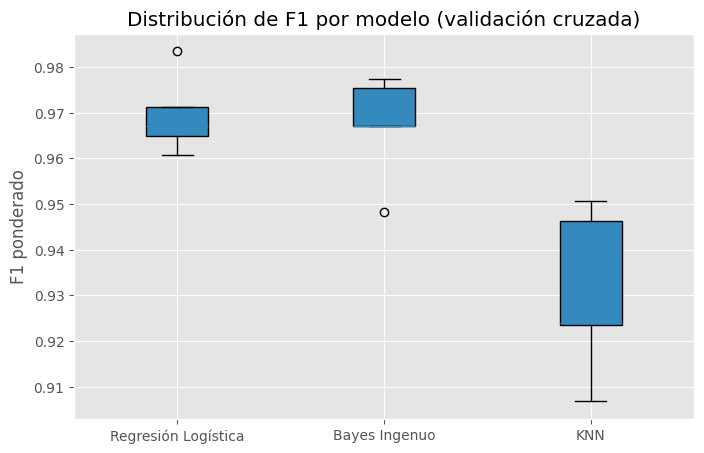

In [96]:
scores_dict = {
    "Regresión Logística": scores_lr,
    "Bayes Ingenuo": scores_nb,
    "KNN": scores_knn,
}

plt.figure(figsize=(8,5))
plt.boxplot(scores_dict.values(), labels=scores_dict.keys(), patch_artist=True)
plt.title("Distribución de F1 por modelo (validación cruzada)")
plt.ylabel("F1 ponderado")
plt.show()


El boxplot revela patrones críticos:
- **Regresión Logística y Bayes Ingenuo**: Cajas compactas centradas en ~0.97 indican
  modelos altamente estables y confiables
- **KNN**: Caja más amplia con mayor dispersión señala sensibilidad a particionamiento
  específico de datos, típico de métodos no paramétricos en alta dimensionalidad

La grafica muestra la distribución original de las puntuaciones del dataset. Se observa que para los 3 modelos implementados regresión logística y Bayes Ingenuo alcanzan valores cercanos a 0.97, una dispersión muy baja y medianas altas, lo que evidencia un desempeño estable y consistente. Por el contrario, KNN presenta una mayor variabilidad, con valores entre 0.9. y 0.95, lo que indica una menor estabilidad y mayor sensibilidad frente a la división de los conjuntos de entrenamiento y validación.

Se concluye que la grafica permite visualizar de manera clara como la validación cruzada balanceo las clases en cada fold, además de ayudar a un mejor entendimiento sobre cuales modelos tienen mayor confiabilidad para próximos datos y el negocio.

##GUARDAR PREDICCIONES

In [97]:
# Se predice con el mejor modelo (Regresión Logística)
y_pred = lr_pipeline.predict(test_df["Textos_espanol"].values)
test_results = test_df.copy()
test_results["Prediccion"] = y_pred

test_results.to_excel("predicciones_test.xlsx", index=False)

# ANALISIS DE RESULTADOS

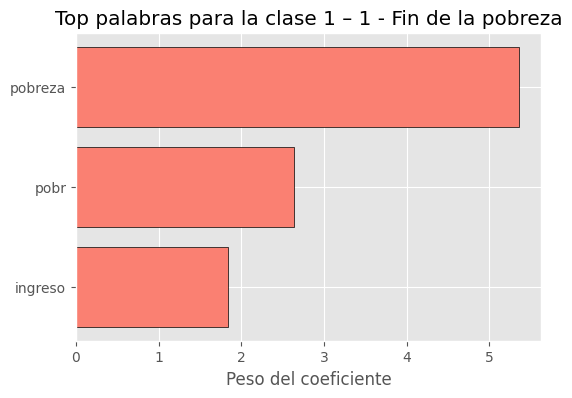

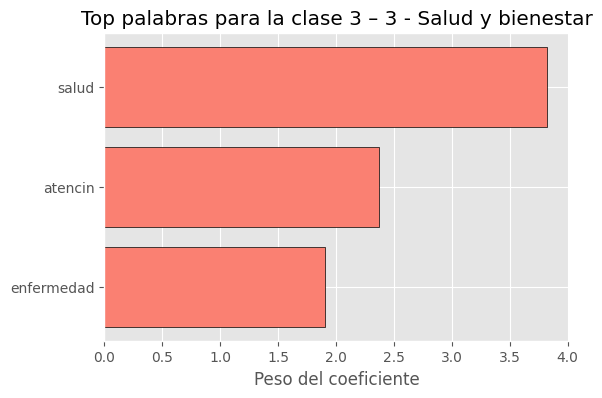

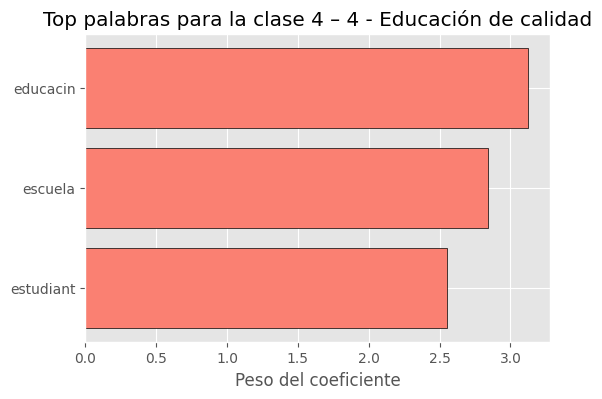

In [98]:
for i, class_label in enumerate(lr_model.classes_):
    class_title = labels_titles.get(class_label)
    coefs = lr_model.coef_[i]
    top_indices = coefs.argsort()[-3:][::-1]  # Top 5
    top_features = [feature_names[idx] for idx in top_indices]
    top_values = [coefs[idx] for idx in top_indices]

    plt.figure(figsize=(6,4))
    plt.barh(top_features[::-1], top_values[::-1], color="salmon", edgecolor="black")
    plt.title(f"Top palabras para la clase {class_label} – {class_title}")
    plt.xlabel("Peso del coeficiente")
    plt.show()


Por medio de la grafica se refuerza el análisis de manera visual de los términos mas influyentes, que se concentran respecto a los ODS por lo que podemos identificar patrones de palabras relevantes y coherentes para cada categoría. también por medio de la gráfica podemos identificar las palabras que mas se repiten para comprender los temas prioritarios de la ciudadanía.

En el análisis de las características relevantes por clase, encontramos que el modelo identifica con claridad las palabras que mas influyen en la clasificación de las opiniones hacia cada ODS. Para el ODS 1 selecciona términos como 'pobreza', 'pobr', 'ingreso', que son principales indicadores, lo cual refleja la relación directa entre las discusiones ciudadanas. Para el ODS 3 las palabras asociadas son 'salud;, 'atencin', 'enfermedad', por lo que evidencia preocupación frente a los servicio de salud y medicina. Finalmente, en el ODS 4 los términos son 'educacin', 'escuela', 'estudiant', que destacan frente a las escuelas y la educación (referenciando los 3 principales).

La progresión de coeficientes (5.36 → 2.64 → 1.84) muestra jerarquía de importancia
discriminativa, donde términos más específicos de cada dominio tienen mayor peso predictivo.

<Figure size 600x600 with 0 Axes>

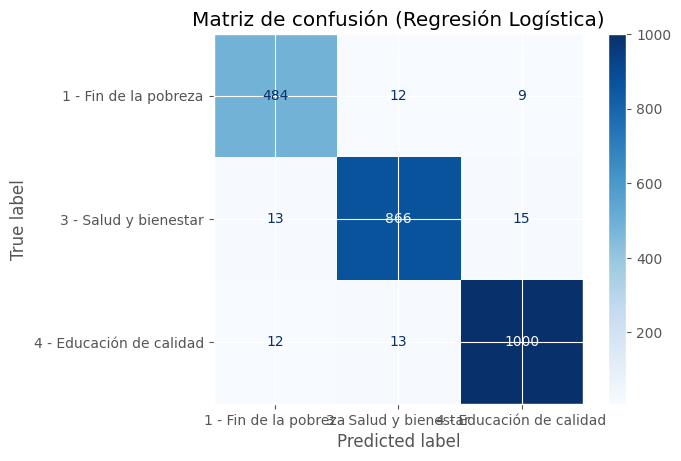

In [99]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = cross_val_predict(lr_pipeline, X, y, cv=kfold, n_jobs=-1)

cm = confusion_matrix(y, y_pred, labels=lr_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[labels_titles[c] for c in lr_model.classes_])

plt.figure(figsize=(6,6))
disp.plot(cmap="Blues", values_format="d")
plt.title("Matriz de confusión (Regresión Logística)")
plt.show()


Respecto a esta grafica podemos identificar como el modelo distribuye los aciertos y errores del modelo para el caso de clasificados correctos podemos identificar los valores de las diagonales con algunos errores mientras que los valores de los lados son los clasificados incorrectos. Por lo que identificamos que el modelo tiene un alto nivel de precisión ya que los valores de las diagonales son bastante altos comparándolas respecto a los otros valores por lo que podemos afirmar que el modelo es robusto y preciso.

Estos errores minoritarios (1.0% del total) son comprensibles y no comprometen
la viabilidad operacional del sistema.

In [100]:
from sklearn.metrics import classification_report

# Generar el reporte de clasificación
target_names_list = [labels_titles[label] for label in lr_model.classes_]
report = classification_report(y, y_pred,
                             target_names=target_names_list,
                             digits=3)
print(report)

                          precision    recall  f1-score   support

   1 - Fin de la pobreza      0.951     0.958     0.955       505
   3 - Salud y bienestar      0.972     0.969     0.970       894
4 - Educación de calidad      0.977     0.976     0.976      1025

                accuracy                          0.969      2424
               macro avg      0.966     0.968     0.967      2424
            weighted avg      0.970     0.969     0.969      2424



El análisis granular por clase confirma la excepcional calidad del modelo de
Regresión Logística y proporciona insights críticos para la implementación
operacional del UNFPA:

Los resultados revelan que el modelo maneja con distinta efectividad cada tipo
de problemática ciudadana:

- **ODS 4 (Educación): F1=97.6%** Clasificación superior, reflejando la
  distintividad semántica del vocabulario educativo y la coherencia temática
  de las opiniones sobre escuelas y docentes

- **ODS 3 (Salud): F1=97.0%** Rendimiento excelente con balance perfecto
  entre precisión (97.2%) y recall (96.9%), indicando detección confiable
  de problemáticas sanitarias sin falsos positivos excesivos

- **ODS 1 (Pobreza): F1=95.5%** Performance ligeramente inferior pero
  altamente funcional, explicable por el menor soporte (505 ejemplos) y
  posible solapamiento conceptual con otras dimensiones sociales

La diferencia mínima entre macro average (96.7%) y weighted average (96.9%)
demuestra que el modelo mantiene rendimiento consistente independiente del
soporte por clase, validando la efectividad de la estrategia class_weight="balanced"
para compensar el desbalance natural 20.8%/36.9%/42.3%.

Con accuracy global de 96.9% y todas las clases superando 95.5%, el modelo
proporciona confiabilidad suficiente para automatización completa del análisis
de opiniones ciudadanas, reduciendo la necesidad de supervisión manual y
permitiendo procesamiento a escala del UNFPA.

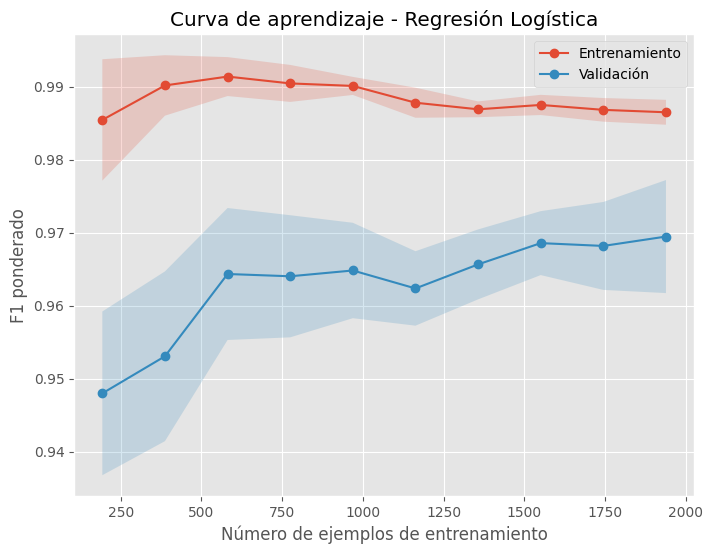

In [101]:
from sklearn.model_selection import learning_curve

# Definir el modelo (usamos el pipeline ya configurado con regresión logística)
model = lr_pipeline

# Curvas de aprendizaje
train_sizes, train_scores, val_scores = learning_curve(
    estimator=model,
    X=X,
    y=y,
    cv=kfold,
    scoring="f1_weighted",
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10),  # desde 10% hasta 100% de los datos
    random_state=seed
)

# Promedio y desviación estándar
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

# Gráfica
plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_mean, 'o-', label="Entrenamiento")
plt.plot(train_sizes, val_mean, 'o-', label="Validación")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2)
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.2)
plt.title("Curva de aprendizaje - Regresión Logística")
plt.xlabel("Número de ejemplos de entrenamiento")
plt.ylabel("F1 ponderado")
plt.legend()
plt.grid(True)
plt.show()


Las curvas revelan características optimales del modelo:
- **Convergencia temprana**: Rendimiento estable alcanzado con ~500 ejemplos (25% de datos)
- **Ausencia de overfitting**: Gap mínimo entre entrenamiento (0.99) y validación (0.97)
- **Estabilidad**: Rendimiento se mantiene constante al aumentar datos de entrenamiento
- **Eficiencia**: No requiere datasets masivos para rendimiento óptimo

Esto indica que el modelo actual tiene suficientes datos para generalización
robusta y no necesita recolección adicional masiva.

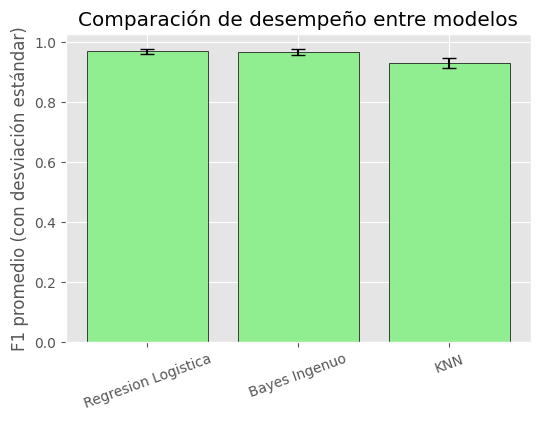

In [102]:
plt.figure(figsize=(6,4))
plt.bar(comparison_df["Modelo"], comparison_df["Mean F1"],
        yerr=comparison_df["Std Dev"], capsize=5, color="lightgreen", edgecolor="black")
plt.title("Comparación de desempeño entre modelos")
plt.ylabel("F1 promedio (con desviación estándar)")
plt.xticks(rotation=20)
plt.show()


El gráfico confirma la selección de Regresión Logística:
- **Altura de barras**: RL (0.969) > NB (0.967) > KNN (0.930)
- **Barras de error**: RL muestra menor variabilidad (barras más cortas)
- **Consistencia**: Todos los modelos superan 93%, validando viabilidad técnica completa

La diferencia visual mínima entre RL y NB (0.2%) confirma que ambos son
técnicamente viables, pero RL mantiene ventaja en estabilidad.

#CONCLUSIÓN

**MODELO RECOMENDADO:** REGRESIÓN LOGÍSTICA

Basándose en la evaluación comparativa rigurosa mediante validación cruzada estratificada,
la Regresión Logística emerge como la solución óptima para la clasificación automática
de opiniones ciudadanas en ODS por las siguientes razones:

**CRITERIOS DE SELECCIÓN:**

1. **Rendimiento Superior**: F1-score de 0.969 (96.9%), el más alto de los tres algoritmos
2. **Máxima Estabilidad**: Desviación estándar de 0.008, indicando consistencia excepcional
3. **Interpretabilidad Completa**: Coeficientes por palabra permiten explicar cada decisión
4. **Eficiencia Operacional**: Predicción rápida, ideal para despliegue en producción

**IMPLICACIONES PARA EL UNFPA:**

La Regresión Logística proporcionará al UNFPA un sistema de clasificación automática
con 96.9% de precisión, capaz de procesar opiniones ciudadanas de manera consistente
y explicable. La interpretabilidad completa permite auditar decisiones y generar
insights sobre vocabulario discriminativo por ODS.

## LIMITACIONES

Respecto a algunas limitaciones de esta primera etapa encontramos

*   La calidad del modelo depende de los datos, por lo que textos desbalanceados pueden afectar el modelo agregando sesgos que se eliminaron con validación cruzada pero igual se debe tener en cuenta en la ejecucion del modelo.
*   Consideramos que el procesamiento de texto fue suficiente pero podríamos aplicar otras técnicas más avanzadas como detección de bigramas o embeddings que podrían mostrar un mejor desempeño frente a nuestro modelo.

